<a href="https://colab.research.google.com/github/jacksonmcl/Federal_Funds_Rate_Model/blob/main/2.%20Data%20Visualization/data_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.transforms as mtransforms
from datetime import datetime
from functools import reduce

dfs = {}

### Github Setup

In [ ]:
! apt-get install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.12).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
!git -C "Federal_Funds_Rate_Model" pull || git clone https://github.com/jacksonmcl/Federal_Funds_Rate_Model.git "Federal_Funds_Rate_Model"

Already up to date.


### Read Data

In [ ]:
dfs['Federal_Funds_Rate'] = pd.read_csv('Federal_Funds_Rate_Model/2. Data Visualization/clean_Federal_Funds_Rate.csv')
dfs['Lagged_FFER'] = pd.read_csv('Federal_Funds_Rate_Model/2. Data Visualization/clean_Lagged_FFR.csv')

dfs['Discount_Rate'] = pd.read_csv('Federal_Funds_Rate_Model/2. Data Visualization/clean_Discount_Rate.csv')
dfs['Prime_Rate'] = pd.read_csv('Federal_Funds_Rate_Model/2. Data Visualization/clean_Prime_Loan_Rate.csv')

dfs['Consumer_Price_Index'] = pd.read_csv('Federal_Funds_Rate_Model/2. Data Visualization/clean_Consumer_Price_Index.csv')
dfs['Producer_Price_Index'] = pd.read_csv('Federal_Funds_Rate_Model/2. Data Visualization/clean_Producer_Price_Index.csv')
dfs['Personal_Consumption_Expenditure'] = pd.read_csv('Federal_Funds_Rate_Model/2. Data Visualization/clean_Personal_Consumption_Expenditures.csv')
dfs['GDP_Recession_Index'] = pd.read_csv('Federal_Funds_Rate_Model/2. Data Visualization/clean_GDP_Recession_Index.csv')

dfs['Unemployment_Rate'] = pd.read_csv('Federal_Funds_Rate_Model/2. Data Visualization/clean_Unemployment_Rate.csv')
dfs['Mortgage_Rate'] = pd.read_csv('Federal_Funds_Rate_Model/2. Data Visualization/clean_Mortgage_Rate.csv')
dfs['Auto_Loan_Rate'] = pd.read_csv('Federal_Funds_Rate_Model/2. Data Visualization/clean_Auto_Loan_Rate.csv')

target_df = dfs.pop('Federal_Funds_Rate')

# Helper Functions

In [ ]:
# This function cleans a dataframe to change datetime to %Y-%m format
def df_dates_monthly(df, Date = 'Date'):
    clean_df = df.copy()
    clean_df[Date] = pd.to_datetime(clean_df[Date])
    clean_df[Date] = clean_df[Date].dt.strftime('%Y-%m')
    return clean_df

In [ ]:
def df_change_percent(df, Value = 'Value'):
    clean_df = df.copy()
    clean_df['ChangePercentMonth'] = round(clean_df[Value].pct_change(),6)
    clean_df['ChangePercentYear'] = round(clean_df[Value].pct_change(12),6)
    return clean_df

In [ ]:
def plot_comparison(base_df, comparison_df, base_label, comparison_label, Value='Value'):
    base_df = base_df.copy()
    comparison_df = comparison_df.copy()

    base_df.dropna(inplace=True)
    comparison_df.dropna(inplace=True)

    # Convert to Datetime
    base_df['Date'] = pd.to_datetime(base_df['Date'])
    comparison_df['Date'] = pd.to_datetime(comparison_df['Date'])

    # Plot comparison metric
    plt.figure(figsize=(12, 6))
    plt.stackplot(base_df['Date'], base_df[Value], color='lightgray')
    sns.lineplot(x='Date', y=Value, data=comparison_df, label=comparison_label, color='steelblue')

    # Customize plot
    plt.title(f'{base_label} and {comparison_label}')
    plt.xlabel('Date')
    plt.ylabel(f'{comparison_label}')
    plt.grid(True)
    plt.legend()
    plt.show()


# Correlations

In [ ]:
for label, df in dfs.items():
  df.drop(columns=['ChangePercentMonth', 'ChangePercentYear'], axis=1, inplace=True)
  df.dropna(inplace=True)
  df.drop_duplicates(inplace=True)

merged_dfs = {k:pd.merge(v, target_df, how='left', on='Date') for (k,v) in dfs.items()}

In [ ]:
# Calculate correlations between different variables to Target
corr_list = {
            k:v[['Value_x', 'Value_y']].corr().iat[0,1] # [0,1] is the location on the correlation matrix that has the correlation of Value_x to Value_y
            for (k,v)
            in merged_dfs.items()
        }

# Print correlations of each dataset to Target
print(f'Correlations with The Federal Funds Effective Rate:\n')
for k,v in corr_list.items():
    print(f'\t{k}: {round(v,2)}')

In [ ]:
# Merge the values and plot a pairplot
dataset_list_values = {k:v[['Date', 'Value']] for (k,v) in dfs.items()}
dataset_list_values['Federal_Funds_Rate'] = target_df[['Date', 'Value']]
dataset_list_values.keys()

In [ ]:
merged_values = reduce(lambda left,right: pd.merge(left,right,on='Date', how='outer'), dataset_list_values.values())
merged_values.columns = ['Date'] + list(dataset_list_values.keys())
# sns.pairplot(data = merged_values)

In [ ]:
# Plot a correlation matrix heatmap
f = plt.figure(figsize=(10, 10))
sns.heatmap(merged_values.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")

# Graph Visualizations

In [ ]:
# Scale Data for Graphing
clean_dfs = {}
for label, df in dfs.items():
  clean_df = df.copy()
  clean_df.columns = ['Date', 'Value']
  clean_dfs[label] = clean_df

## Target Comparison (Value)

Lagged_FFER
      Date  Value
0  1954-08   0.80
1  1954-09   1.22
2  1954-10   1.07
3  1954-11   0.85
4  1954-12   0.83


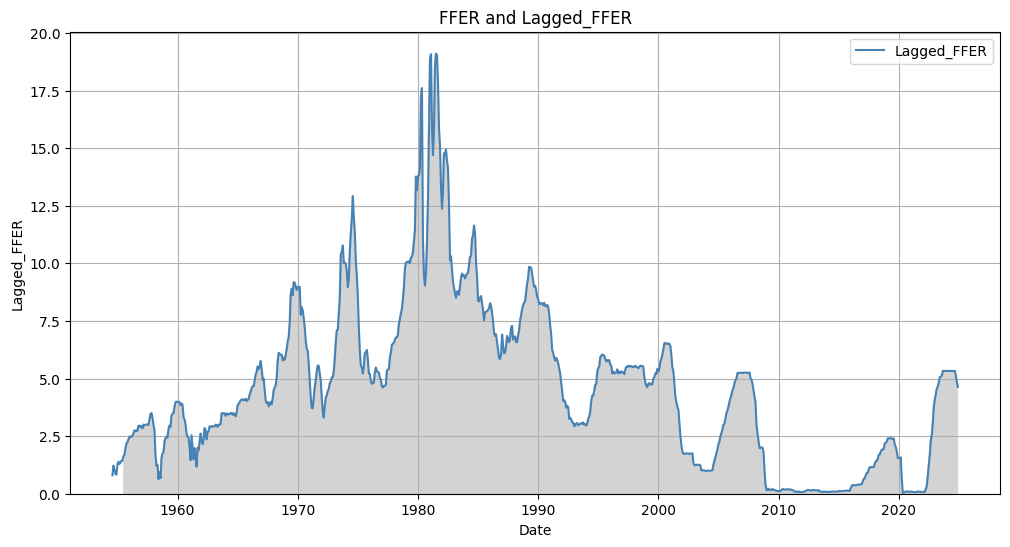

Discount_Rate
      Date  Value
0  1954-07    1.5
1  1954-08    1.5
2  1954-09    1.5
3  1954-10    1.5
4  1954-11    1.5


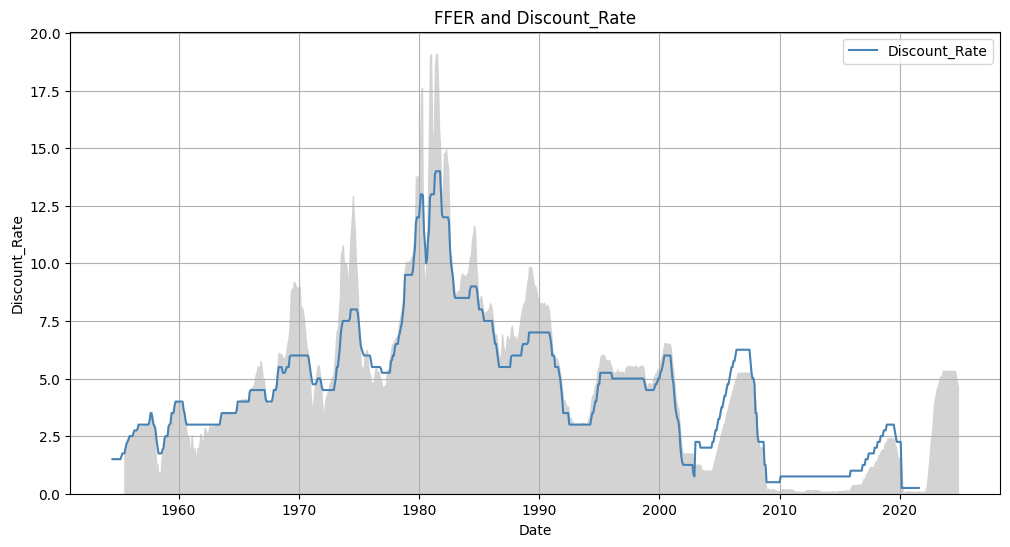

Prime_Rate
      Date  Value
0  1955-08   3.25
3  1955-09   3.25
4  1955-10   3.25
5  1955-10   3.50
7  1955-11   3.50


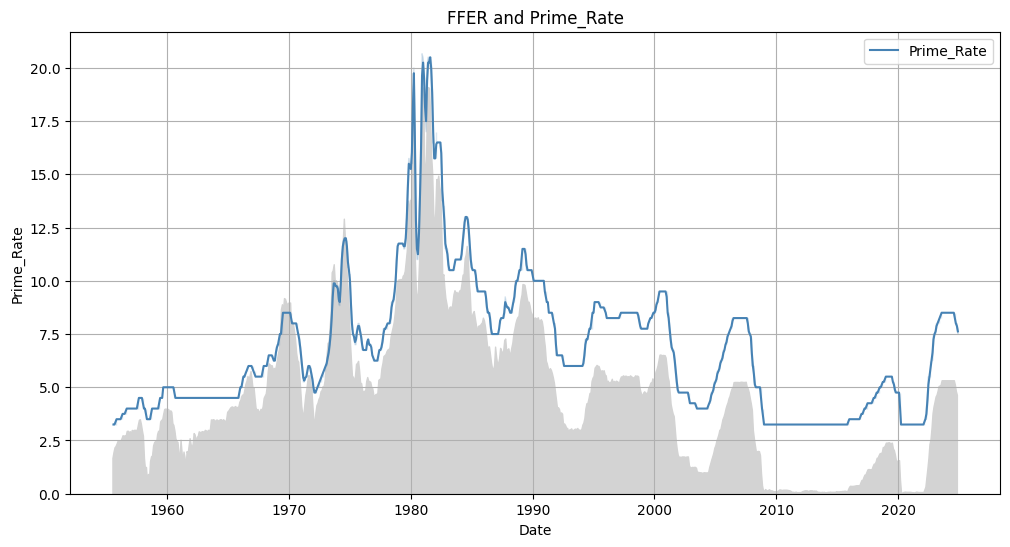

Consumer_Price_Index
      Date  Value
0  1954-07  26.86
1  1954-08  26.85
2  1954-09  26.81
3  1954-10  26.72
4  1954-11  26.78


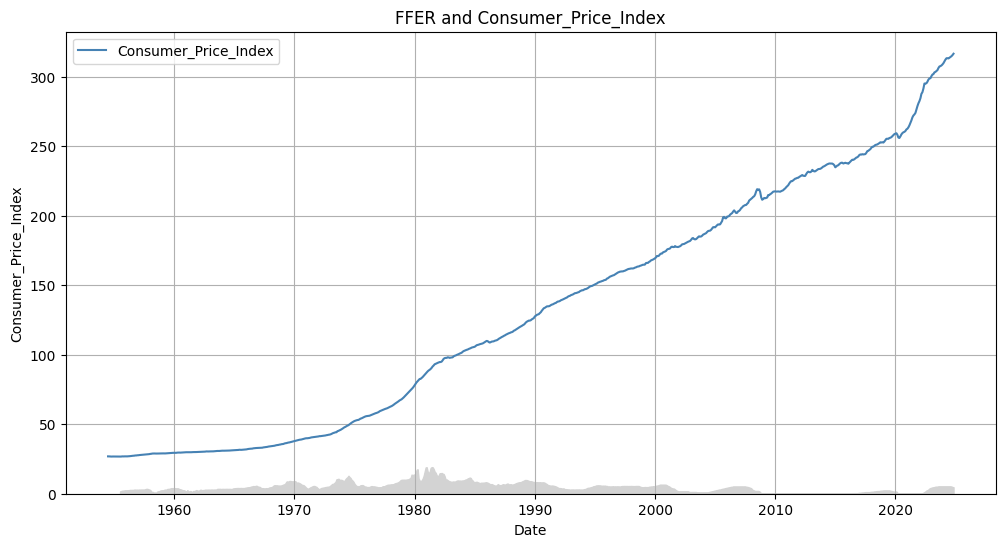

Producer_Price_Index
      Date  Value
0  1954-07   29.3
1  1954-08   29.3
2  1954-09   29.2
3  1954-10   29.1
4  1954-11   29.2


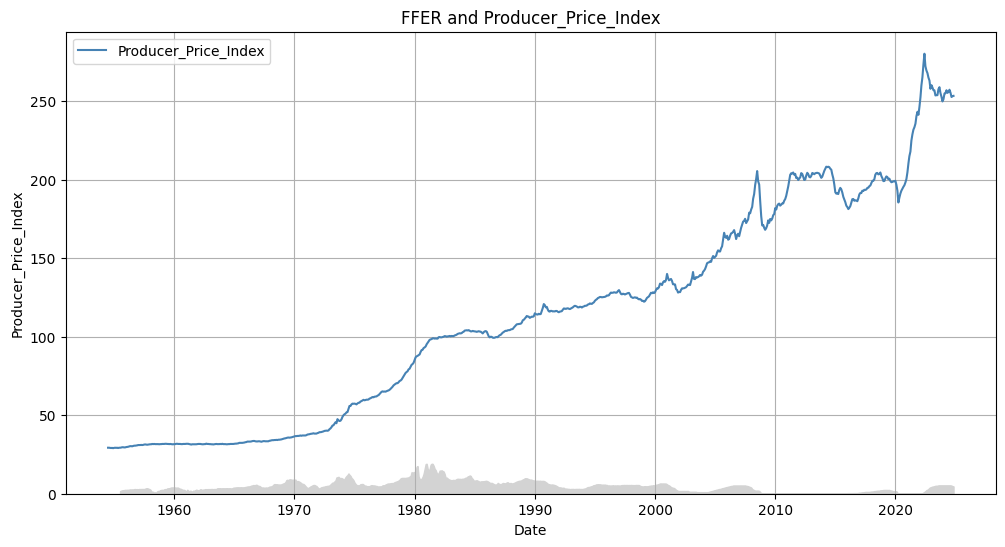

Personal_Consumption_Expenditure
      Date  Value
0  1959-01  306.1
1  1959-02  309.6
2  1959-03  312.7
3  1959-04  312.2
4  1959-05  316.1


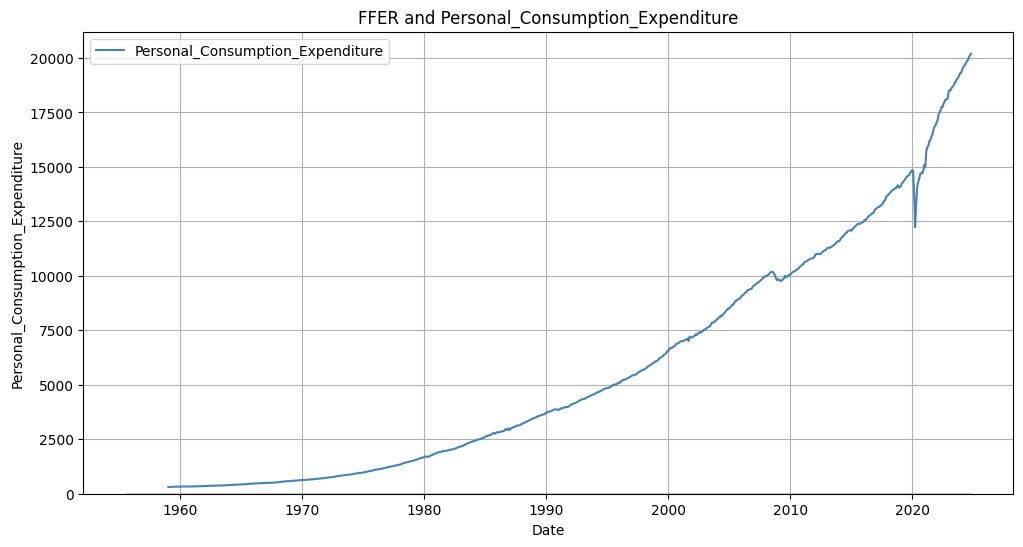

GDP_Recession_Index
      Date   Value
0  1967-10  3.8348
1  1968-01  1.7614
2  1968-04  1.2127
3  1968-07  2.3009
4  1968-10  6.3338


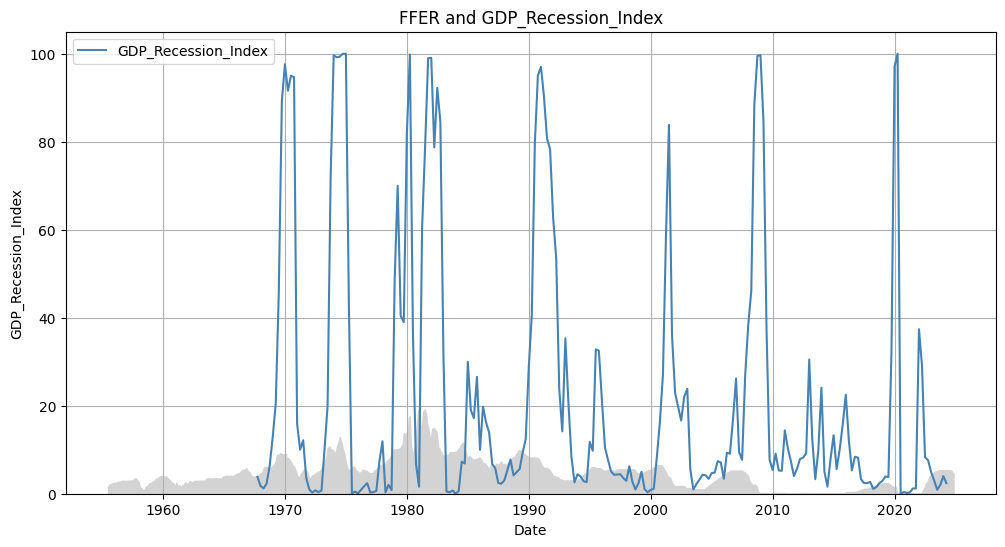

Unemployment_Rate
      Date  Value
0  1954-07    5.8
1  1954-08    6.0
2  1954-09    6.1
3  1954-10    5.7
4  1954-11    5.3


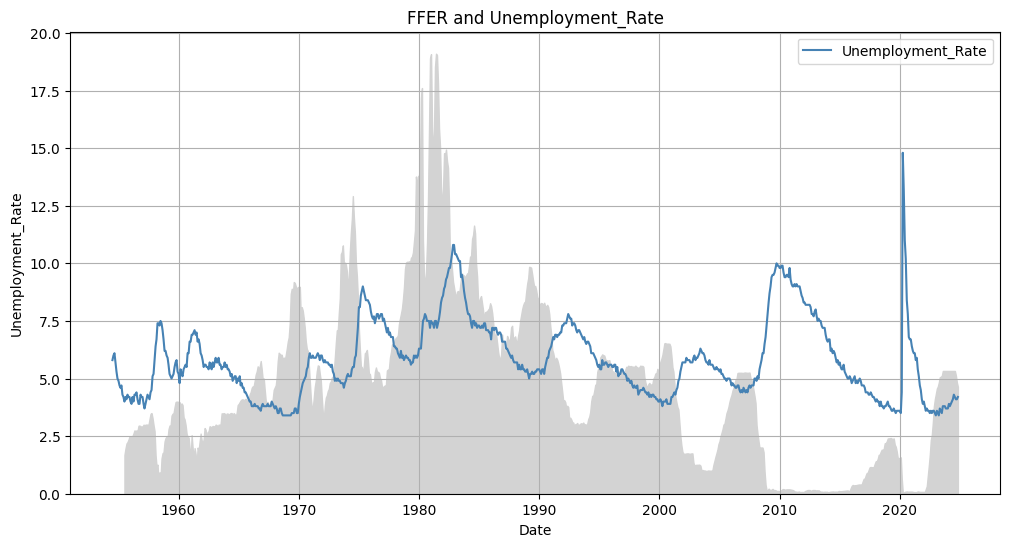

Mortgage_Rate
      Date  Value
0  1971-04   7.33
1  1971-04   7.31
3  1971-04   7.29
4  1971-05   7.38
5  1971-05   7.42


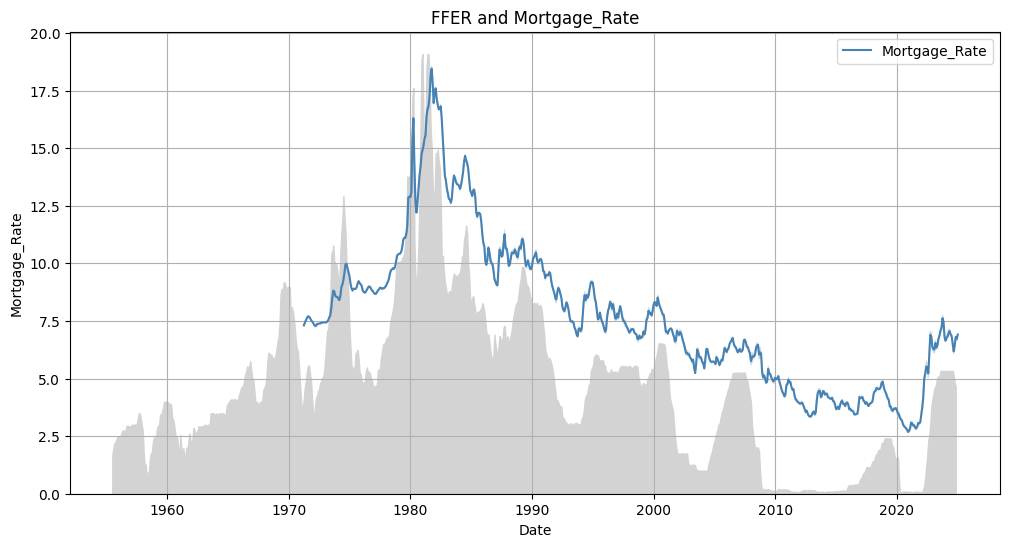

Auto_Loan_Rate
       Date  Value
0   1972-02  10.20
3   1972-05   9.96
6   1972-08  10.02
9   1972-11  10.02
12  1973-02  10.05


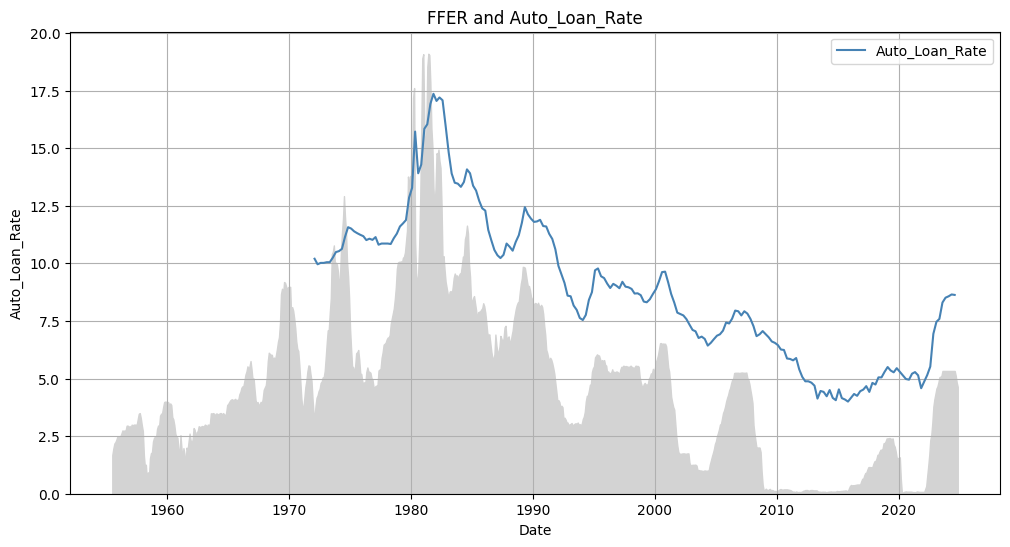

In [115]:
for label, df in clean_dfs.items():
  print(label)
  print(df.head())
  plot_comparison(target_df, df, 'FFER', label)


## Target Comparison (Monthly)

In [ ]:
for label, df in clean_dfs.items():
  plot_comparison(target_df, df, 'FFER', label, Value='ChangePercentMonth')

## Target Comparison (Annually)

In [ ]:
for label, df in clean_dfs.items():
  plot_comparison(target_df, df, 'FFER', label, Value='ChangePercentYear')